<a href="https://colab.research.google.com/github/prateekrao/Breast-Cancer-Classification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BREAST CANCER CLASSIFICATION**

## **Unzipping the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/split-data.zip"

## **Importing required libraries**

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

## **Preparing Image Dataset**

* Using image data generator to rescale and normalize the images.
* Images are of size 50x50

In [ ]:
gen = ImageDataGenerator(
    rescale = 1/255
)

In [ ]:
# Defining the path
BASE_PATH = "/content/split-data"

In [ ]:
train_set = gen.flow_from_directory(
    directory = os.path.join(BASE_PATH, 'train'),
    target_size = (50,50),
    class_mode = 'sparse',
    shuffle = True,
    color_mode = 'rgb'
)

Found 194266 images belonging to 2 classes.


In [ ]:
test_set = gen.flow_from_directory(
    directory = os.path.join(BASE_PATH, 'test'),
    target_size = (50,50),
    class_mode = 'sparse',
    shuffle = False,
    color_mode = 'rgb'
)

Found 41629 images belonging to 2 classes.


In [ ]:
validation_set = gen.flow_from_directory(
    directory = os.path.join(BASE_PATH, 'valid'),
    target_size= (50,50),
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = True
)

Found 41629 images belonging to 2 classes.


## **Building the model**

### **Importing the Pre-trained Architecture**

* Architecure used is ResNet50V2. 
* First time training using imagenet weights

In [ ]:
resnet = ResNet50V2(include_top = False, weights = 'imagenet', input_shape = (50,50,3))

94674944/94668760 [==============================] - 1s 0us/step


Freezing all the layers of the pretrained model, so that the weights don't update

In [ ]:
resnet.trainable = False

### **Function to create the structure of the model**

* Using regularizer to prevent overfitting

In [ ]:
def create_model():
  
  model = tf.keras.Sequential()

  model.add(resnet)
  model.add(GlobalAveragePooling2D())

  model.add(Dense(512, activation='relu', kernel_regularizer=l1(l1=0.01)))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation= 'relu', kernel_regularizer=l2(l2=0.01)))
  model.add(Dense(2, activation='softmax'))

  return model

## **Creating the model**

In [ ]:
model = create_model()

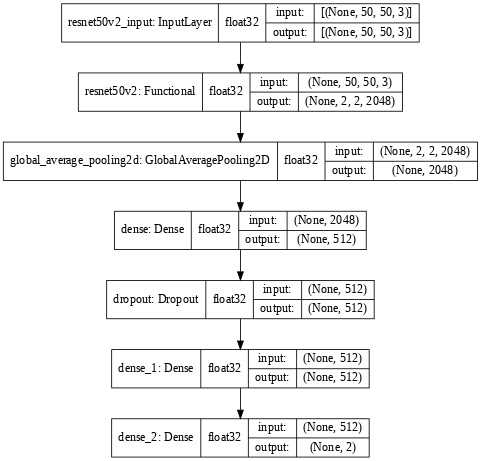

In [ ]:
tf.keras.utils.plot_model(
            model,
            to_file="model.png",
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            expand_nested=False,
            rankdir='TB',
            dpi=60
)

* Optimizer used is *Adam*, with a learning rate of (0.001)
* Loss function used is *SparseCategoricalCrossentropy*

In [ ]:
model.compile(optimizer = Adam(lr=1e-03), loss= 'sparse_categorical_crossentropy', metrics = ['accuracy'])

* Using `keras.callbacks` to create checkpoint, for *early stopping*, incase the validation accuracy doesn't improve too much

In [ ]:
early = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    mode = 'max',
    min_delta = 0.005,
    verbose =1
)

## **Training the Model**

* Fitting the model to the dataset

In [ ]:
history = model.fit(train_set, validation_data=validation_set, callbacks = early, epochs = 13, shuffle = True)

Epoch 1/13
6071/6071 [==============================] - 142s 23ms/step - loss: 1.8427 - accuracy: 0.7605 - val_loss: 1.7295 - val_accuracy: 0.7864
Epoch 2/13
6071/6071 [==============================] - 138s 23ms/step - loss: 1.7883 - accuracy: 0.7629 - val_loss: 1.5660 - val_accuracy: 0.7845
Epoch 3/13
6071/6071 [==============================] - 138s 23ms/step - loss: 1.7857 - accuracy: 0.7622 - val_loss: 1.9953 - val_accuracy: 0.7657
Epoch 4/13
6071/6071 [==============================] - 138s 23ms/step - loss: 1.7922 - accuracy: 0.7631 - val_loss: 1.9639 - val_accuracy: 0.7857
Epoch 5/13
6071/6071 [==============================] - 138s 23ms/step - loss: 1.7933 - accuracy: 0.7614 - val_loss: 1.5916 - val_accuracy: 0.7745
Epoch 6/13
6071/6071 [==============================] - 138s 23ms/step - loss: 1.7883 - accuracy: 0.7607 - val_loss: 1.7813 - val_accuracy: 0.7772
Epoch 00006: early stopping


## **Fine-Tuning the model**

> Un-freezing the layers of ResNet, so that weights can update, for finetuning

In [ ]:
resnet.trainable = True

> Recompiling the model

In [ ]:
model.compile(optimizer = Adam(lr=1e-05), loss= 'sparse_categorical_crossentropy', metrics = ['accuracy'])

## **Re-Training the Model**

* Creating a model checkpoint, using `keras.callbacks`, to monitor the validation accuracy and to save only the best model in the HDF5 Format

In [ ]:
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/cancer-retrain.h5",
    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1
)

In [ ]:
history = model.fit(train_set, validation_data = validation_set, epochs = 7, callbacks= checkpoint, shuffle = True)

Epoch 1/7
6071/6071 [==============================] - 378s 61ms/step - loss: 0.5534 - accuracy: 0.8099 - val_loss: 0.3822 - val_accuracy: 0.8687

Epoch 00001: val_accuracy improved from -inf to 0.86870, saving model to /content/drive/MyDrive/cancer-retrain.h5
Epoch 2/7
6071/6071 [==============================] - 373s 61ms/step - loss: 0.4044 - accuracy: 0.8527 - val_loss: 0.3472 - val_accuracy: 0.8803

Epoch 00002: val_accuracy improved from 0.86870 to 0.88025, saving model to /content/drive/MyDrive/cancer-retrain.h5
Epoch 3/7
6071/6071 [==============================] - 373s 61ms/step - loss: 0.3672 - accuracy: 0.8700 - val_loss: 0.3379 - val_accuracy: 0.8814

Epoch 00003: val_accuracy improved from 0.88025 to 0.88140, saving model to /content/drive/MyDrive/cancer-retrain.h5
Epoch 4/7
6071/6071 [==============================] - 371s 61ms/step - loss: 0.3402 - accuracy: 0.8842 - val_loss: 0.3368 - val_accuracy: 0.8811

Epoch 00004: val_accuracy did not improve from 0.88140
Epoch 5/7

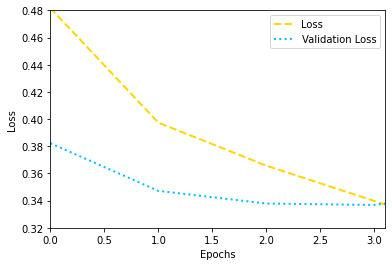

In [ ]:
plt.plot(history.history['loss'], label = 'Loss', linestyle='dashed', color= 'gold', linewidth=2)
plt.plot(history.history['val_loss'], label = 'Validation Loss', linestyle = ':', color = 'deepskyblue', linewidth = 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.32, 0.48)
plt.xlim(0,3.1)
plt.legend(loc = "upper right")

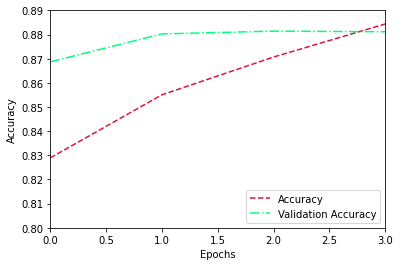

In [ ]:
plt.plot(history.history['accuracy'], label = 'Accuracy', linestyle = '--' , color='crimson')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', linestyle = 'dashdot', color='springgreen')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.8, 0.89)
plt.xlim(0, 3)
plt.legend(loc = "lower right")

In [ ]:
predictions = model.predict(test_set)

In [ ]:
%matplotlib inline

In [ ]:
rounded_pred = np.argmax(predictions, axis=-1)

In [ ]:
cm = confusion_matrix(y_true=test_set.classes, y_pred=rounded_pred)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="green" if cm[i, j] > thresh else "red", fontdict={'fontsize':'x-large'})

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['one','zero']

Confusion matrix, without normalization
[[ 9270  2548]
 [ 2960 26851]]


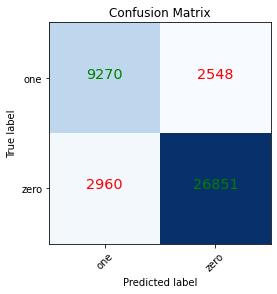

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
model.evaluate(test_set)

1301/1301 [==============================] - 25s 19ms/step - loss: 0.3776 - accuracy: 0.8677


[0.377631276845932, 0.8676884174346924]